In [1]:
import pandas as pd
import numpy as np
import json
import math
import matplotlib.pyplot as plt
%matplotlib inline

#### Getting the data ready

In [2]:
loans = pd.read_csv(r"D:\Classification\Project 7\data\lending-club-data.csv")

C:\Users\Govind\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
loans.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.14350,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.39320,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1.0,1.0,1.0,0,8.25955,20141201T000000,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,...,0.2,1.0,1.0,1.0,0,8.27585,20141201T000000,0,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,...,0.8,1.0,1.0,1.0,0,5.21533,20141201T000000,1,1,1


#### Extracting the target and the feature columns

In [4]:
# safe_loans =  1 => safe
# safe_loans = -1 => risky
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.drop('bad_loans', axis = 1)

In [5]:
features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]
target = 'safe_loans'
loans = loans[features + [target]]

In [6]:
loans.head()

,grade,term,home_ownership,emp_length,safe_loans
0,B,36 months,RENT,10+ years,1
1,C,60 months,RENT,< 1 year,-1
2,C,36 months,RENT,10+ years,1
3,C,36 months,RENT,10+ years,1
4,A,36 months,RENT,3 years,1


In [7]:
loans = pd.get_dummies(loans)

In [8]:
with open(r"D:\Classification\Project 7\data\train-idx.json") as f:
    train_idx=json.load(f)
with open(r"D:\Classification\Project 7\data\test-idx.json") as f:
    test_idx=json.load(f)

In [9]:
train_data = loans.iloc[train_idx].reset_index()
test_data = loans.iloc[test_idx].reset_index()
train_data = train_data.drop('index', 1)
test_data = test_data.drop('index',1)

## Weighted decision trees

#### Weighted error definition

Predictions $\hat{y}_1,…,\hat{y}_n$

Target $y_1,…,y_n$

Data point weights $α_1,…,α_n$

Then the **weighted error** is defined by:

$$E(α,\hat{\textbf{y}}) = \frac{\sum_{i=1}^{n}α_i*I[y_i \neq \hat{y_i}]}{\sum_{i=1}^{n}α_i}$$


In [10]:
def intermediate_node_weighted_mistakes(labels_in_node, data_weights):
    '''
    labels_in_node: y_1,…,y_n
    data_weights: Data point weights α_1,…,α_n
    Return: the tuple (weight, class_label) representing the lower of the two weights. 
    If the two weights are identical, return (weighted_mistakes_all_positive,+1) 
    '''
    # Sum the weights of all entries with label +1
    #print(labels_in_node)
    #print('---------xxx--------')
    #print(len(data_weights))
    total_weight_positive = sum(data_weights[labels_in_node == +1])
    
    # Weight of mistakes for predicting all -1's is equal to the sum above
    weighted_mistakes_all_negative = total_weight_positive
    
    # Sum the weights of all entries with label -1
    total_weight_negative = sum(data_weights[labels_in_node == -1])
    
    # Weight of mistakes for predicting all +1's is equal to the sum above
    weighted_mistakes_all_positive = total_weight_negative
    
    return min((weighted_mistakes_all_positive,+1),(weighted_mistakes_all_negative,-1))
    

#### Function to pick best feature to split on

In [11]:
def best_splitting_feature(data, features, target, data_weights):
    
    # These variables will keep track of the best feature and the corresponding error
    best_feature = None
    best_error = float('+inf') 
    
    num_points = float(len(data))

    # Looping through each feature to consider splitting on that feature
    for feature in features:
        
        # The left split will have all data points where the feature value is 0
        # The right split will have all data points where the feature value is 1
        left_split = data[data[feature] == 0]
        right_split = data[data[feature] == 1]
        left_data_weights = data_weights[data[feature] == 0]
        right_data_weights = data_weights[data[feature] == 1]
                    
        left_weighted_mistakes, left_class = intermediate_node_weighted_mistakes(left_split[target], left_data_weights)
        right_weighted_mistakes, right_class = intermediate_node_weighted_mistakes(right_split[target], right_data_weights)
        
        error = (left_weighted_mistakes + right_weighted_mistakes)/sum(data_weights)
        
        # If this is the best error we have found so far, store the feature and the error
        if error < best_error:
            best_feature = feature
            best_error = error
    
    return best_feature

#### Building the tree

In [12]:
def create_leaf(target_values, data_weights):
    
    leaf = {'splitting_feature' : None,
            'is_leaf': True}
    
    weighted_error, best_class = intermediate_node_weighted_mistakes(target_values, data_weights)
    leaf['prediction'] = best_class
    
    return leaf

In [13]:
def weighted_decision_tree_create(data, features, target, data_weights, current_depth = 1, max_depth = 10):
    remaining_features = features[:] # Make a copy of the features.
    target_values = data[target]
    print("--------------------------------------------------------------------")
    print("Subtree, depth = %s (%s data points)." % (current_depth, len(target_values)))
    
    # Stopping condition 1. Error is 0.
    if intermediate_node_weighted_mistakes(target_values, data_weights)[0] <= 1e-15:
        print("Stopping condition 1 reached.")                
        return create_leaf(target_values, data_weights)
    
    # Stopping condition 2. No more features.
    if remaining_features == []:
        print("Stopping condition 2 reached.")                
        return create_leaf(target_values, data_weights)    
    
    # Stopping condition 3. Limit tree depth.
    if current_depth > max_depth:
        print("Reached maximum depth. Stopping for now.")
        return create_leaf(target_values, data_weights)
    
    # If all the datapoints are the same, splitting_feature will be None. Create a leaf
    splitting_feature = best_splitting_feature(data, features, target, data_weights)
    remaining_features.remove(splitting_feature)
        
    left_split = data[data[splitting_feature] == 0]
    right_split = data[data[splitting_feature] == 1]
    
    left_data_weights = data_weights[data[splitting_feature] == 0]
    right_data_weights = data_weights[data[splitting_feature] == 1]
    
    print("Split on feature %s. (%s, %s)" % (\
              splitting_feature, len(left_split), len(right_split)))
    
    # Create a leaf node if the split is "perfect"
    if len(left_split) == len(data):
        print("Creating leaf node.")
        return create_leaf(left_split[target], data_weights)
    if len(right_split) == len(data):
        print("Creating leaf node.")
        return create_leaf(right_split[target], data_weights)
    
    # Repeat (recurse) on left and right subtrees
    left_tree = weighted_decision_tree_create(
        left_split, remaining_features, target, left_data_weights, current_depth + 1, max_depth)
    right_tree = weighted_decision_tree_create(
        right_split, remaining_features, target, right_data_weights, current_depth + 1, max_depth)
    
    return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': splitting_feature,
            'left'             : left_tree, 
            'right'            : right_tree}

In [14]:
def count_nodes(tree):
    if tree['is_leaf']:
        return 1
    return 1 + count_nodes(tree['left']) + count_nodes(tree['right'])

#### Making predictions with a weighted decision tree

In [15]:
def classify(tree, x, annotate = False):   
    # If the node is a leaf node.
    if tree['is_leaf']:
        if annotate: 
            print("At leaf, predicting %s" % tree['prediction'])
        return tree['prediction'] 
    else:
        # Split on feature.
        split_feature_value = x[tree['splitting_feature']]
        if annotate: 
            print("Split on %s = %s" % (tree['splitting_feature'], split_feature_value))
        if split_feature_value == 0:
            return classify(tree['left'], x, annotate)
        else:
            return classify(tree['right'], x, annotate)

#### Evaluating the tree

In [16]:
def evaluate_classification_error(tree, data):
    prediction = data.apply(lambda x: classify(tree, x),axis=1)
    return (prediction != data[target]).sum() / float(len(data))

In [17]:
# Assign weights
example_data_weights = np.concatenate((np.ones(10),np.zeros(len(train_data) - 20),np.ones(10)))

In [18]:
example_data_weights

array([1., 1., 1., ..., 1., 1., 1.])

In [19]:
features = [i for i in train_data.columns]
features.remove('safe_loans')

In [20]:
# Train a weighted decision tree model.
small_data_decision_tree_subset_20 = weighted_decision_tree_create(train_data, features, target,
                         example_data_weights, max_depth=2)

--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature home_ownership_RENT. (20514, 16710)
--------------------------------------------------------------------
Subtree, depth = 2 (20514 data points).
Split on feature grade_F. (19613, 901)
--------------------------------------------------------------------
Subtree, depth = 3 (19613 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (901 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 2 (16710 data points).
Split on feature grade_D. (13315, 3395)
--------------------------------------------------------------------
Subtree, depth = 3 (13315 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 3 (3395 data points).
Stoppin

In [21]:
subset_20 = train_data.head(10).append(train_data.tail(10))

In [22]:
evaluate_classification_error(small_data_decision_tree_subset_20, subset_20)

0.05

In [23]:
evaluate_classification_error(small_data_decision_tree_subset_20, train_data)

0.48124865678057166

* The points with higher weights are the ones that are more important during the training process of the weighted decision tree.

* The points with zero weights are basically ignored during training.

#### Implementing Adaboost (on decision stumps)
$$
\hat{w_t}=\frac{1}{2}ln\Big(\frac{1−E(α,\hat{\textbf{y}})}{E(α,\hat{\textbf{y}})}\Big)\\
\\
$$
$$
\alpha_j \gets \begin{cases} \alpha_j \exp{(-\hat{w}_t)} & \text{ if }f_t(x_j) = y_j\\\alpha_j \exp{(\hat{w}_t)} & \text{ if }f_t(x_j) \neq y_j \end{cases}\\
$$
Normalize weights:
$$
\alpha_j \gets \dfrac{\alpha_j}{\sum_{i=1}^{N}{\alpha_i}}
$$

In [24]:
def adaboost_with_tree_stumps(data, features, target, num_tree_stumps):
    # start with unweighted data
    alpha = np.ones(len(data))
    weights = []
    tree_stumps = []
    target_values = data[target]
    
    for t in range(num_tree_stumps):
        print('=====================================================')
        print('Adaboost Iteration %d' % t)
        print('=====================================================')       
        # Learn a weighted decision tree stump. Use max_depth=1
        tree_stump = weighted_decision_tree_create(data, features, target, data_weights=alpha, max_depth=1)
        tree_stumps.append(tree_stump)

        predictions = data.apply(lambda x: classify(tree_stump, x),axis=1)
        
        # Produce a Boolean array indicating whether
        # each data point was correctly classified
        is_correct = predictions == target_values
        is_wrong   = predictions != target_values

        weighted_error = weighted_error = sum(alpha[is_wrong])/sum(alpha)
        
        # Compute model coefficient using weighted error
        weight = 0.5*math.log((1-weighted_error)/weighted_error)
        weights.append(weight)
        
        # Adjust weights on data point
        adjustment = is_correct.apply(lambda is_correct : math.exp(-weight) if is_correct else math.exp(weight))
        
        # Scale alpha by multiplying by adjustment
        # Then normalize data points weights
        alpha = alpha*adjustment
        alpha= alpha/sum(alpha)
    
    return weights, tree_stumps

#### Training a boosted ensemble of 10 stumps

In [25]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, target, num_tree_stumps=10)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
---------------------------------

#### Making predictions
$$\displaystyle \hat{y} = \mathrm{sign}\left(\sum_{t=1}^T \hat{w}_t f_t(x)\right)$$

In [26]:
def predict_adaboost(stump_weights, tree_stumps, data):
    scores = np.zeros(len(data))
    
    for i, tree_stump in enumerate(tree_stumps):
        predictions = data.apply(lambda x: classify(tree_stump, x),axis=1)
        
        # Accumulate predictions on scaores array
        scores += (stump_weights[i] * predictions)
        
    return scores.apply(lambda score : +1 if score > 0 else -1)

In [27]:
stump_weights

[0.15802933659263743,
 0.1768236329364191,
 0.09311888971129693,
 0.07288885525840554,
 0.06706306914118143,
 0.06456916961644447,
 0.05456055779178564,
 0.04351093673362621,
 0.02898871150041245,
 0.01933343817072769]

In [28]:
predictions = predict_adaboost(stump_weights, tree_stumps, test_data)

In [29]:
accuracy = float(sum(test_data[target] == predictions))/len(test_data)

In [30]:
accuracy

0.6220379146919431

#### Performance plots

In [31]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, 
                                 features, target, num_tree_stumps=30)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
---------------------------------

Split on feature grade_E. (33815, 3409)
--------------------------------------------------------------------
Subtree, depth = 2 (33815 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (3409 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 15
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature emp_length_4 years. (34593, 2631)
--------------------------------------------------------------------
Subtree, depth = 2 (34593 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (2631 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 16
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_F. (35512, 1712)
---------

Adaboost Iteration 29
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_C. (27812, 9412)
--------------------------------------------------------------------
Subtree, depth = 2 (27812 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (9412 data points).
Reached maximum depth. Stopping for now.


#### Computing training error at the end of each iteration

In [32]:
error_all = []
for n in range(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], train_data)
    accuracy = float(sum(train_data[target] == predictions))/len(train_data)
    error = 1.0 - accuracy
    error_all.append(error)
    print("Iteration %s, training error = %s" % (n, error_all[n-1]))

Iteration 1, training error = 0.4216365785514722
Iteration 2, training error = 0.43343004513217276
Iteration 3, training error = 0.4000376101439931
Iteration 4, training error = 0.4000376101439931
Iteration 5, training error = 0.3847249086610789
Iteration 6, training error = 0.3846174511068128
Iteration 7, training error = 0.3827638082957232
Iteration 8, training error = 0.3846174511068128
Iteration 9, training error = 0.3827638082957232
Iteration 10, training error = 0.38144745325596385
Iteration 11, training error = 0.38144745325596385
Iteration 12, training error = 0.38144745325596385
Iteration 13, training error = 0.38144745325596385
Iteration 14, training error = 0.38144745325596385
Iteration 15, training error = 0.38144745325596385
Iteration 16, training error = 0.3814205888673974
Iteration 17, training error = 0.3814205888673974
Iteration 18, training error = 0.3816355039759295
Iteration 19, training error = 0.3816355039759295
Iteration 20, training error = 0.3816355039759295
It

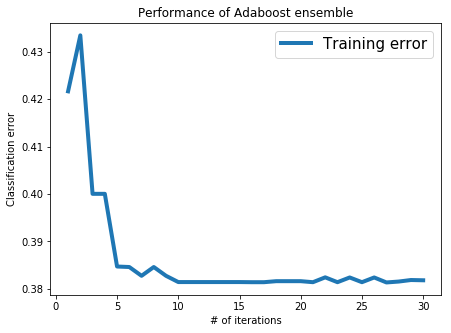

In [33]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.legend(loc='best', prop={'size':15})

plt.rcParams.update({'font.size': 16})

#### Evaluation on the test data

In [34]:
test_error_all = []
for n in range(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], test_data)
    accuracy = float(sum(test_data[target] == predictions))/len(test_data)
    error = 1.0 - accuracy
    test_error_all.append(error)
    print("Iteration %s, test error = %s" % (n, test_error_all[n-1]))

Iteration 1, test error = 0.4233089185695821
Iteration 2, test error = 0.4284791038345541
Iteration 3, test error = 0.3981042654028436
Iteration 4, test error = 0.3981042654028436
Iteration 5, test error = 0.37990090478242133
Iteration 6, test error = 0.38000861697544164
Iteration 7, test error = 0.37925463162429984
Iteration 8, test error = 0.38000861697544164
Iteration 9, test error = 0.37925463162429984
Iteration 10, test error = 0.37796208530805686
Iteration 11, test error = 0.37796208530805686
Iteration 12, test error = 0.37796208530805686
Iteration 13, test error = 0.37796208530805686
Iteration 14, test error = 0.37796208530805686
Iteration 15, test error = 0.37796208530805686
Iteration 16, test error = 0.37817750969409736
Iteration 17, test error = 0.37817750969409736
Iteration 18, test error = 0.37785437311503667
Iteration 19, test error = 0.37785437311503667
Iteration 20, test error = 0.37785437311503667
Iteration 21, test error = 0.37817750969409736
Iteration 22, test error =

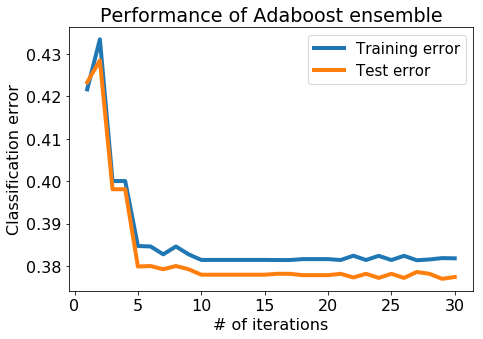

In [35]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.plot(range(1,31), test_error_all, '-', linewidth=4.0, label='Test error')

plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.rcParams.update({'font.size': 16})
plt.legend(loc='best', prop={'size':15})
plt.tight_layout()